In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
import math
from tqdm import tqdm
import faiss
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

C:\Users\16142\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wine = pd.read_csv('../Data/Raw Data/winemag-data-130k-v2.csv', encoding='utf-8', on_bad_lines='skip')
wine.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [3]:
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


# PCA Visualization

In [4]:
description_embeddings = torch.load("../Data/description_embeddings.pt")
# labels are just the wine id's
vector_labels = wine.id.astype(str).tolist()

## PCA on all reviews

In [5]:
# Apply PCA to all vectors
pca = PCA(n_components=2)
transformed_vectors = pca.fit_transform(description_embeddings)

## Plot top n most common grape varieties

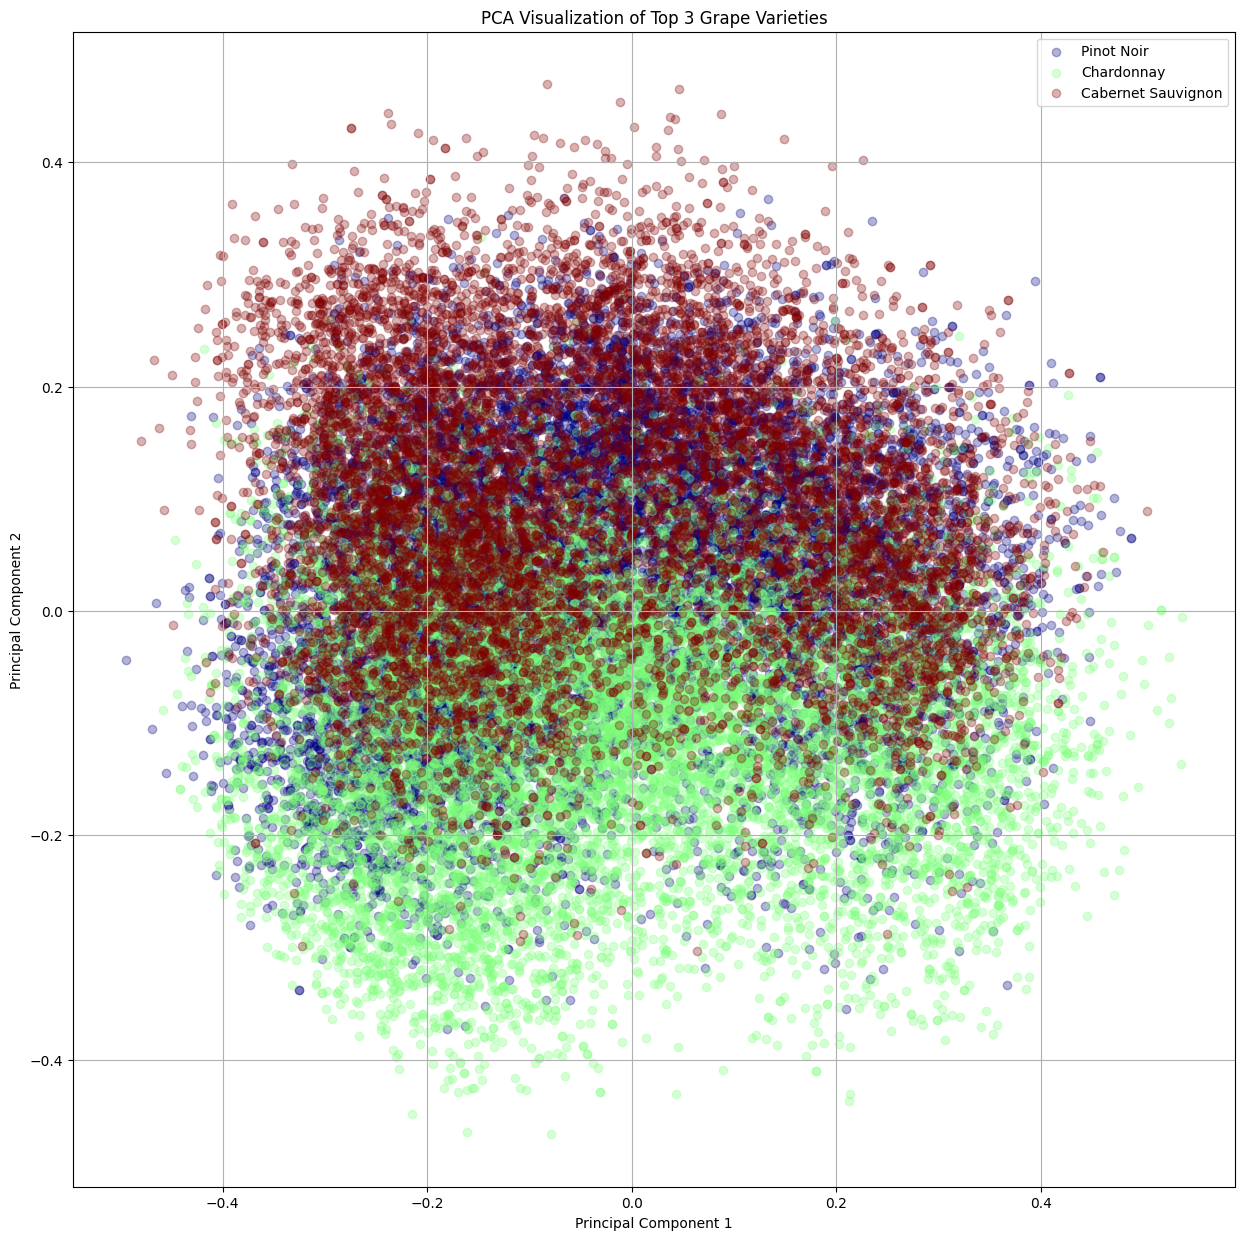

In [6]:
# get the grape variety info
# Extract grape variety information
grape_varieties = wine['variety'].tolist()

# Count the occurrences of each grape variety
variety_counts = wine['variety'].value_counts()

# Get the n most common grape varieties here I have n=3
top_varieties = variety_counts.head(3).index.tolist()

# Filter the vectors, labels, and colors based on these top varieties
filtered_indices = [i for i, variety in enumerate(grape_varieties) if variety in top_varieties]

filtered_vectors = transformed_vectors[filtered_indices]
filtered_varieties = [grape_varieties[i] for i in filtered_indices]

# Assign a unique color to each of the top n grape varieties
colors = plt.cm.jet(np.linspace(0, 1, len(top_varieties)))
color_map = dict(zip(top_varieties, colors))
filtered_colors = [color_map[variety] for variety in filtered_varieties]

# Visualize with a scatter plot
plt.figure(figsize=(15, 15))

# Scatter plot with color-coding by grape variety
for variety, color in color_map.items():
    indices = [i for i, v in enumerate(filtered_varieties) if v == variety]
    plt.scatter(filtered_vectors[indices, 0], filtered_vectors[indices, 1], color=color, label=variety, alpha=0.3)

plt.title("PCA Visualization of Top 3 Grape Varieties")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
#plt.savefig("PCA_Top_3_Grape_varieties.png", dpi=300, bbox_inches="tight")
plt.show()

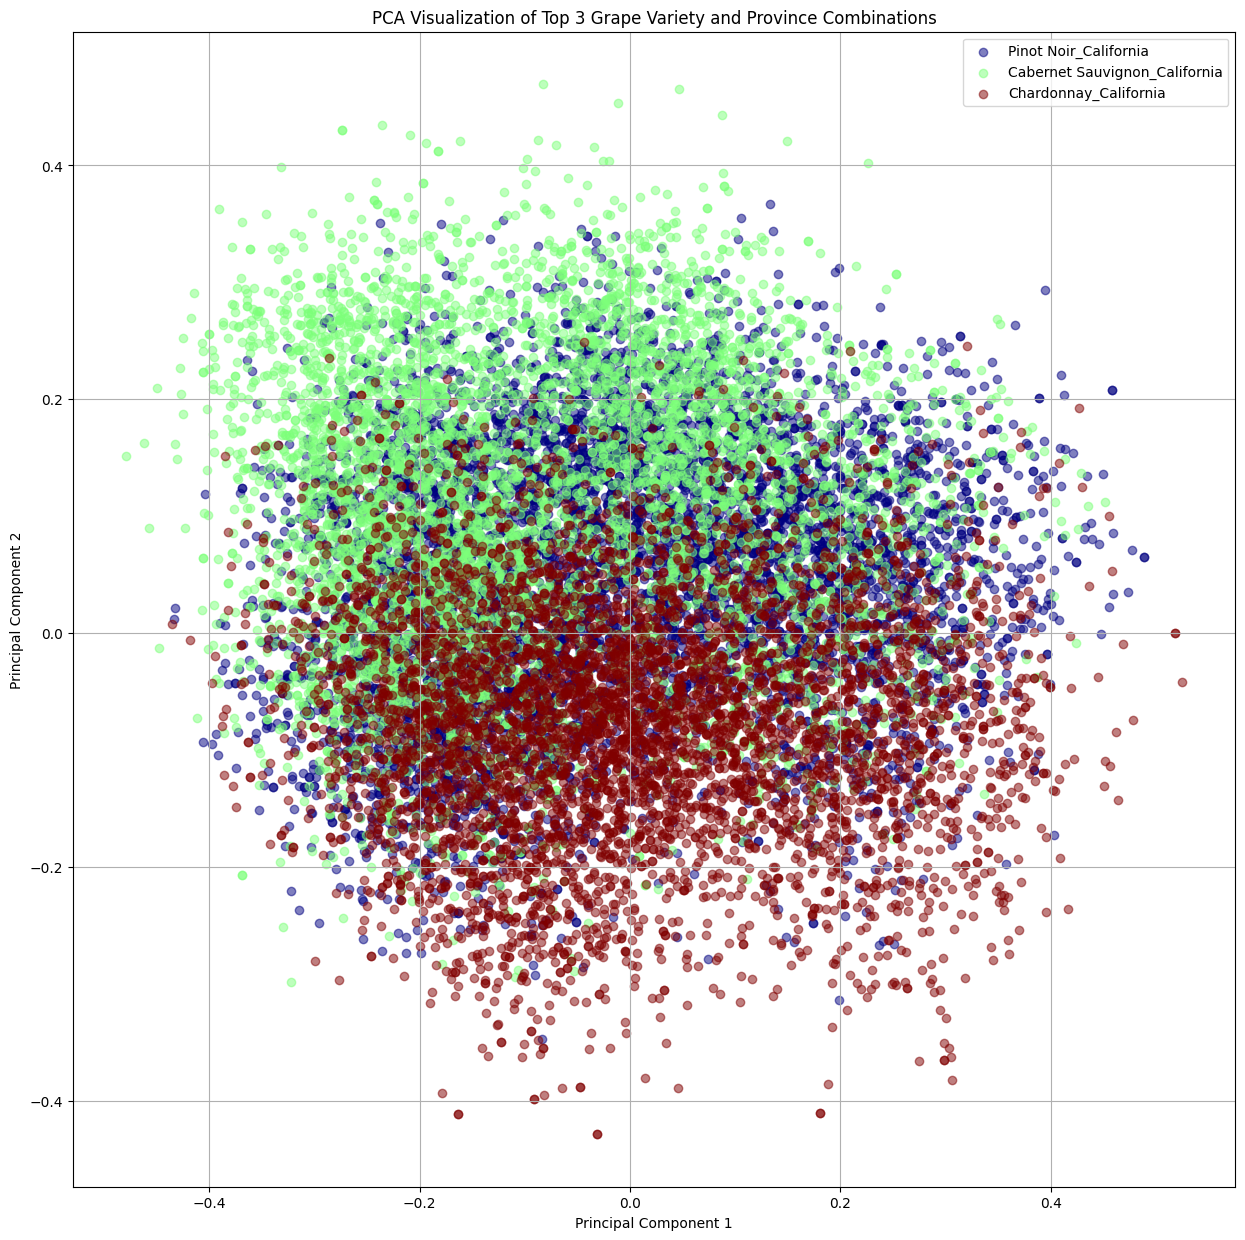

In [8]:
# Combine grape variety and province
wine['variety_province'] = wine['variety'] + '_' + wine['province']

# Get the combined labels for all data points
combined_labels = wine['variety_province'].tolist()

# Count occurrences of each variety_province combination
combination_counts = wine['variety_province'].value_counts()

# Get the top n = 3 most common variety_province combinations
top_combinations = combination_counts.head(3).index.tolist()

# Filter the vectors and labels based on these top n combinations
filtered_indices = [i for i, label in enumerate(combined_labels) if label in top_combinations]
filtered_vectors = transformed_vectors[filtered_indices]
filtered_labels = [combined_labels[i] for i in filtered_indices]

# Create a color map for the top n combinations
colors_combined = plt.cm.jet(np.linspace(0, 1, len(top_combinations)))
color_map_combined = dict(zip(top_combinations, colors_combined))

# Visualize with a scatter plot
plt.figure(figsize=(15, 15))

# Scatter plot with color-coding by top n grape variety and province combinations
for label, color in color_map_combined.items():
    indices = [i for i, v in enumerate(filtered_labels) if v == label]
    plt.scatter(filtered_vectors[indices, 0], filtered_vectors[indices, 1], color=color, label=label, alpha=0.5)

plt.title("PCA Visualization of Top 3 Grape Variety and Province Combinations")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
# Uncomment the next line if you want to save the figure
# plt.savefig("PCA_Top_3_Variety_and_Province.png", dpi=300, bbox_inches="tight")
plt.show()
